In [1]:
#hide
%matplotlib inline
import datetime

import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
from sunode.wrappers.as_theano import solve_ivp
import sunode
import sympy as sym
from scipy import interpolate
import xarray as xr

import requests
import io

sns.set_context('talk')
plt.style.use('seaborn-whitegrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
import load_covid_data

## Data

In [3]:
df_sign = load_covid_data.load_data(filter_n_days_100=10)
df_sign = df_sign[df_sign.state.isna()]

countries = pd.Series(df_sign.country.unique())
countries = countries.loc[~countries.isin(['Cruise Ship (total)', 'Cruise Ship', 'China (total)'])]
n_countries = len(countries)
countries = countries.rename('country').to_frame().set_index('country')

In [4]:
df_sign = df_sign.reset_index()
df_sign.index.name = 'observation'

previous = (
    df_sign
    .reset_index()
    .groupby(['country'])
    .apply(
        lambda x:
        x.set_index('date')
        .assign(date=x.date.values)
        .sort_index()
        .shift()
    )
)

df_sign = (
    df_sign
    .reset_index()
    .set_index(['country', 'date'])
    .assign(
        previous_date=previous.date,
        previous_confirmed=previous.confirmed,
    )
    .reset_index()
    .set_index('observation')
)

df_sign['new_confirmed'] = df_sign.eval('confirmed - previous_confirmed')
df_sign['days_since_last_data'] = (df_sign['date'] - df_sign['previous_date']).dt.days
df_sign = df_sign.dropna(subset=['new_confirmed'])

## Growth Rate Predictions

In [5]:
pop_file = 'https://github.com/datasets/population/raw/master/data/population.csv'
populations = pd.read_csv(pop_file)
populations = populations.sort_values(['Country Name', 'Year']).groupby(['Country Name']).last()

idxs = populations.index.get_indexer([c.replace('(total)', '').strip() for c in countries.index])
countries['population'] = [populations.iloc[i].Value if idx != -1 else pd.NA for i, idx in enumerate(idxs)]

In [6]:
countries.loc['Egypt', 'population'] = populations.loc['Egypt, Arab Rep.'].Value
countries.loc['Iran', 'population'] = populations.loc['Iran, Islamic Rep.'].Value
countries.loc['Korea, South', 'population'] = populations.loc['Korea, Rep.'].Value
countries.loc['Hong Kong', 'population'] = populations.loc['Hong Kong SAR, China'].Value
countries.loc['Czechia', 'population'] = populations.loc['Czech Republic'].Value
countries.loc['US (total)', 'population'] = populations.loc['United States'].Value

In [7]:
countries['population'] = countries.population.values.astype('d')

In [8]:
multi_country = True

if multi_country:
    max_countries = 100
    countries = countries.iloc[:max_countries]
    n_countries = len(countries)
    df_sign = df_sign[df_sign.country.isin(countries.index)]
else:
    n_countries = 1
    country = 'Italy'

    countries = countries.loc[country: country]
    df_sign = df_sign[df_sign.country == country]    

In [9]:
start_day = df_sign.date.min() - datetime.timedelta(days=1)
end_data_day = df_sign.date.max()
end_day = end_data_day + datetime.timedelta(days=30)

data_time = pd.date_range(start_day, end_data_day)
time = pd.date_range(start_day, end_day)
country = countries.index

In [10]:
x, y = sym.symbols('x, y', real=True)
def sym_expit(x):
    return 1 / (1 + sym.exp(-x))

(sym_expit(x) / sym_expit(y) / sym_expit(-y)).expand()

1/(exp(y) + exp(-x)*exp(y)) + exp(y)/(1 + exp(-x)) + 2/(1 + exp(-x))

In [10]:
def simplify(expr):
    return expr.expand()

In [90]:
log_scale = True

if log_scale:
    def sir_rhs(t, y, p):
        exp = np.vectorize(sym.exp)
        expit = np.vectorize(lambda x: 1 / (1 + sym.exp(-x)))
        #expit = np.vectorize(sunode.symode.lambdify.expit)
        #dexpit = np.vectorize(sunode.symode.lambdify.dexpit)
        
        change = np.array([
            sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
            for i in range(len(y.logit_R))
        ])
        
        infection_rate = exp(np.array(p.log_infection_rate) + change)
        
        S = 1 - expit(y.logit_I) - expit(y.logit_R)

        return {
            'logit_I': (infection_rate * S - p.recovery_rate) / expit(-y.logit_I),
            'logit_R': p.recovery_rate * expit(y.logit_I) / (expit(y.logit_R) * expit(-y.logit_R)),
            #'logit_R': p.recovery_rate * expit(y.logit_I) / dexpit(y.logit_R)
        }
else:
    def sir_rhs(t, y, p):
        exp = np.vectorize(sym.exp)
        
        change = np.array([
            sunode.symode.lambdify.interpolate_spline(t, p.infection_change_polys[i], 0, len(data_time), degree=4)
            for i in range(len(y.R))
        ])
        
        infection_rate = exp(np.array(p.log_infection_rate) + change)
        
        S = 1 - y.I - y.R
        infections = infection_rate * y.I * S
        remissions = p.remission_rate * y.I
        
        return {
            'I': infections - remissions,
            'R': remissions,
        }

with pm.Model() as model:
    log_pop = np.log(countries['population'].values)

    if multi_country:
        sd = pm.HalfNormal('init_logI_sd')
        mu = pm.Normal('init_logI_mu', sd=5)
        raw = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = mu + sd * raw - log_pop
        pm.Deterministic('init_logI', init_logI)
    else:
        init_logI = pm.Normal('init_logI_raw', shape=n_countries)
        init_logI = init_logI - log_pop
        pm.Deterministic('init_logI', init_logI)

    if multi_country:
        sd = pm.HalfNormal('log_infect_sd')
        mu = pm.Normal('log_infect_mu', sd=10)
        raw = pm.Normal('log_infect_raw', shape=n_countries)
        log_infect = mu + sd * raw
        pm.Deterministic('log_infect', log_infect)
    else:
        log_infect = pm.Normal('log_infect', shape=n_countries)

    if multi_country:
        sd = pm.HalfNormal('log_recovery_sd')  # In 1/day/infected
        mu = pm.Normal('log_recovery_mu', mu=-3, sd=8)
        raw = pm.Normal('log_recovery_raw', shape=n_countries)
        log_recovery = mu + sd * raw
        pm.Deterministic('log_recovery', log_recovery)
    else:
        log_recovery = pm.Normal('log_recovery', shape=n_countries)

    sd = pm.HalfNormal('infection_change_polys_sd', sd=2)
    raw = pm.Normal('infection_change_polys_raw', shape=(n_countries, 8))
    infection_change_polys = sd * raw / 100
    pm.Deterministic('infection_change_polys', infection_change_polys)

    if not log_scale:
        init = {
            'I': (tt.exp(init_logI), (n_countries,)),
            'R': (np.zeros(n_countries), (n_countries,)),
        }
    else:
        init = {
            'logit_I': (init_logI - tt.log1p(tt.exp(init_logI)), (n_countries,)),
            'logit_R': (np.full(n_countries, -10, dtype='d'), (n_countries,)),
        }

    params = {
        'recovery_rate': (tt.exp(log_recovery), (n_countries,)),
        'infection_change_polys': (infection_change_polys, (n_countries, 8)),
        'log_infection_rate': (log_infect, (n_countries,)),
        '_placeholder': (np.zeros(n_countries), (n_countries,)),
    }

    separate_odes = False

    if separate_odes:
        solutions = []
        problems = []
        solvers = []
        for i in range(n_countries):
            init_i = {
                name: (var[i:i+1], (1, *shape_others))
                for i, (name, (var, (_, *shape_others))) in enumerate(init.items())
            }
            params_i = {
                name: (var[i:i+1], (1, *shape_others))
                for i, (name, (var, (_, *shape_others))) in enumerate(params.items())
            }

            solution_i, flat_solution, problem, solver, *_ = solve_ivp(
                t0=0,
                y0=init_i,
                params=params_i,
                tvals=np.arange(len(data_time)),
                rhs=sir_rhs,
                solver_kwargs={
                    'solver': 'ADAMS',
                    #'constraints': np.r_[np.ones(n_countries * 3), np.zeros(n_countries)],
                    #'constraints': np.array([1., 1, 1, 0]),
                }
            )
            problems.append(problem)
            solvers.append(solver)
            solutions.append(solution_i)
    
        solution = {}
        for name in init:
            solution[name] = tt.join(1, *[vals[name] for vals in solutions])
    else:
        solution, flat_solution, problem, solver, y0_flat, params_subs_flat = solve_ivp(
            #solution, flat_solution, problem, solver, *_ = solve_ivp(
            t0=0,
            y0=init,
            params=params,
            tvals=np.arange(len(data_time)),
            rhs=sir_rhs,
            simplify=simplify,
            solver_kwargs={
                'solver': 'ADAMS',
                'adjoint_solver': 'ADAMS',
                #'constraints': np.ones(n_countries * 2),
                #'constraints': np.array([1., 1, 1, 0]),
            }
        )


    if log_scale:
        solution['I'] = tt.nnet.sigmoid(solution['logit_I'])
        solution['R'] = tt.nnet.sigmoid(solution['logit_R'])
        solution['S'] = 1 - solution['I'] - solution['R']
    else:
        solution['S'] = 1 - solution['I'] - solution['R']
        
    for name in solution:
        pm.Deterministic(f'solution_{name}', solution[name])

    # The number of people who have at some time been infected
    cases = (1 - solution['S']) * countries.population.values[None, :]

    idx_country = countries.index.get_indexer(df_sign.country)
    idx_data_time = data_time.get_indexer(df_sign.date)
    idx_previous_time = data_time.get_indexer(df_sign.previous_date)
    
    assert -1 not in idx_country
    assert -1 not in idx_data_time
    assert -1 not in idx_previous_time
    
    current_infected = cases[idx_data_time, idx_country]
    previous_infected = cases[idx_previous_time, idx_country]
    mu_confirmed = current_infected
    
    alpha = pm.HalfNormal('confirmed_alpha', shape=n_countries, sd=10)
    pm.Deterministic('mu_confirmed', mu_confirmed)
    pm.NegativeBinomial(
        'confirmed_count',
        mu_confirmed,
        alpha[idx_country],
        observed=np.maximum(0, df_sign['confirmed'].values)
    )
    
    cases = solution['R'] * countries.population.values[None, :]
    
    current_recovered = cases[idx_data_time, idx_country]
    previous_recovered = cases[idx_previous_time, idx_country]
    mu_recovered = current_recovered
    
    alpha = pm.HalfNormal('recovered_alpha', shape=n_countries, sd=10)
    pm.Deterministic('mu_recovered', mu_recovered)
    pm.NegativeBinomial(
        'recovered_count',
        mu_recovered,
        alpha[idx_country],
        observed=np.maximum(0, df_sign['recovered'].values + df_sign['deaths'].values)
    )

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [91]:
lib = sunode._cvodes.lib

In [92]:
jac_prod = problem.make_sundials_jac_prod()
lin_solver = lib.SUNLinSol_SPGMR(solver._state_buffer.c_ptr, lib.PREC_NONE, 5)
lib.SUNLinSolInitialize_SPGMR(lin_solver)

lib.CVodeSetLinearSolver(solver._ode, lin_solver, sunode.basic.ffi.NULL)

lib.CVodeSetJacTimes(solver._ode, sunode.basic.ffi.NULL, jac_prod.cffi)

jac_prod = problem.make_sundials_adjoint_jac_prod()
lin_solverB = lib.SUNLinSol_SPGMR(solver._state_buffer.c_ptr, lib.PREC_NONE, 5)
lib.SUNLinSolInitialize_SPGMR(lin_solverB)

lib.CVodeSetLinearSolverB(solver._ode, solver._odeB, lin_solverB, sunode.basic.ffi.NULL)

lib.CVodeSetJacTimesB(solver._ode, solver._odeB, sunode.basic.ffi.NULL, jac_prod.cffi)

0

In [93]:
lib.CVodeSStolerances(solver._ode, 1e-7, 1e-7)
lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
lib.CVodeSetMaxNumSteps(solver._ode, 5000)
lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 5000)
#lib.CVodeSetMinStep(solver._ode, 1e-12)
#lib.CVodeSetMinStepB(solver._ode, solver._odeB, 1e-12)
lib.CVodeSetMaxOrd(solver._ode, 4)
lib.CVodeSetMaxOrdB(solver._ode, solver._odeB, 4)
#lib.CVodeSetInitStep(solver._ode, 1e-7)
#lib.CVodeSetInitStepB(solver._ode, solver._odeB, -1e-6)
#lib.CVodeSetMaxStep(solver._ode, 50)
#lib.CVodeSetMaxStepB(solver._ode, solver._odeB, 50)

0

In [88]:
y = problem._sym_states

vals = {
    y.logit_I[0]: -1000,
    y.logit_R[0]: -5,
    p.log_infection_rate[0]: 0,
    p.remission_rate[0]: -0.5,
}

In [110]:
func = sym.lambdify([y.logit_I[0], y.logit_R[0], p.log_infection_rate[0], p.remission_rate[0]], problem._sym_dydt[0].expand())
func_adj = sym.lambdify([y.logit_I[0], y.logit_R[0], p.log_infection_rate[0], p.remission_rate[0]], problem._sym_dlamdadt[0].expand())

In [112]:
func(**{var.name: val for var, val in vals.items()})
func_adj(**{var.name: val for var, val in vals.items()})

In [113]:
problem._sym_dlamdadt[0].expand().subs(vals)

lamda_0/(exp(-1000) + 2 + exp(1000)) - 1.5*lamda_0*exp(-1000) + lamda_0*exp(-1000)/(1 + exp(5)) + lamda_0*exp(-1000)/(1 + exp(1000)) + lamda_0*exp(-1000)/(exp(-1000) + 2 + exp(1000)) + 0.5*lamda_20/(exp(-1005) + 2*exp(-5) + exp(995)) + 1.0*lamda_20/(exp(-1000) + 2 + exp(1000)) + 0.5*lamda_20*exp(-5)/(exp(-1000) + 2 + exp(1000))

In [64]:
func = model.logp_dlogp_function()
func.set_extra_values({})

In [65]:
np.random.seed(42)

In [ ]:
x0 = np.random.randn(func.size)
func(x0);

In [19]:
import theano

point = func.array_to_dict(x0)

func_y0 = theano.function(model.free_RVs, y0_flat, on_unused_input='ignore')
y0_div = func_y0(**point)

params_func = theano.function(model.free_RVs, params_subs_flat, on_unused_input='ignore')
params_div = params_func(**point)

solver.set_derivative_params(params_div.view(solver.derivative_params_dtype)[0])

#tvals = np.linspace(0, (ds.time.values * 3600).max(), 1_000_000)
#tvals = ds.time.values * 3600
tvals = np.arange(len(data_time))

y_out, grad_out, lamda_out = solver.make_output_buffers(tvals)
y_out[...] = np.nan

#sunode._cvodes.lib.CVodeSetConstraints(solver._ode, sunode._cvodes.ffi.NULL)

point_ = {var: point[var.name] for var in model.free_RVs}
#point_[y0_flat] = y0_div
flat_y_vals = theano.function(model.free_RVs, flat_solution, on_unused_input='ignore')(**point)
grads_func = theano.function([flat_solution] + model.free_RVs, tt.grad(sum(model[var.name].logpt for var in model.observed_RVs), flat_solution), on_unused_input='ignore')
grads = grads_func(flat_y_vals, **point)

In [69]:
out = sunode._cvodes.ffi.new('long[1]')
lib.CVodeGetNumRhsEvals(solver._ode, out)
out[0]

134

In [70]:
%timeit func(x0)

10.6 ms ± 74.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
import theano
func_dets = theano.function(model.free_RVs, model.deterministics)
dets = {var.name: vals for var, vals in zip(model.deterministics, func_dets(**func.array_to_dict(x0)))}

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [35]:
import theano
func_logps = theano.function(model.free_RVs, [var.logp_elemwiset for var in model.observed_RVs])
logps = {var.name: vals for var, vals in zip(model.observed_RVs, func_logps(**func.array_to_dict(x0)))}

/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [94]:
with model:
    trace = pm.sample(tune=1000, chains=6, cores=6, discard_tuned_samples=False, compute_convergence_checks=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (6 chains in 6 jobs)
NUTS: [recovered_alpha, confirmed_alpha, infection_change_polys_raw, infection_change_polys_sd, log_recovery_raw, log_recovery_mu, log_recovery_sd, log_infect_raw, log_infect_mu, log_infect_sd, init_logI_raw, init_logI_mu, init_logI_sd]


There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


In [95]:
import arviz
ds = arviz.from_pymc3(
    trace=trace,
    coords={
        'data_time': data_time,
        'country': country,
        'time': time,
        'observation': df_sign.index,
        'infection_poly': np.arange(8),
    },
    dims={
        'init_logI_raw': ['country'],
        'init_logI': ['country'],
        'log_infect_raw': ['country'],
        'log_infect': ['country'],
        'log_recovery_raw': ['country'],
        'log_recovery': ['country'],
        'solution_I': ['data_time', 'country'],
        'solution_S': ['data_time', 'country'],
        'solution_R': ['data_time', 'country'],
        'solution_logit_I': ['data_time', 'country'],
        'solution_logit_R': ['data_time', 'country'],
        'solution_log_infection_rate': ['data_time', 'country'],
        'infection_change_polys_raw': ['country', 'infection_poly'],
        'infection_change_polys': ['country', 'infection_poly'],
        'confirmed_alpha': ['country'],
        'recovered_alpha': ['country'],
        'mu_confirmed': ['observation'],
        'mu_recovered': ['observation'],
    },
    log_likelihood=False,
)


tr = ds.posterior
#tr = ds.posterior.isel(draw=slice(1000, None))


vals = (tr.infection_change_polys_raw * tr.infection_change_polys_sd / 100).transpose('infection_poly', ...).values
degree = 4
lower = 0
upper = len(tr.data_time)

n_knots = degree + len(vals) + 1
knots = np.arange(n_knots)
lower_knot = degree #+ lower * (n_knots - 2 * degree - 1)
upper_knot = degree + (n_knots - 2 * degree - 1)

knots = (knots - lower_knot) / (upper_knot - lower_knot)
knots = knots * (upper - lower) + lower

x = np.arange(upper)
spline = interpolate.BSpline(knots, vals.reshape((vals.shape[0], -1)), degree)
#spline_int = spline.antiderivative()
infection_rate_change = (spline(x)).reshape((upper, *vals.shape[1:]))


tr['infection_rate_change'] = (
    ('data_time', *tr.infection_change_polys_raw.transpose('infection_poly', ...).dims[1:]),
    infection_rate_change
)
tr['infection_rate'] = np.exp(tr.infection_rate_change + tr.log_infect)

In [98]:
pop = xr.DataArray(countries['population'])

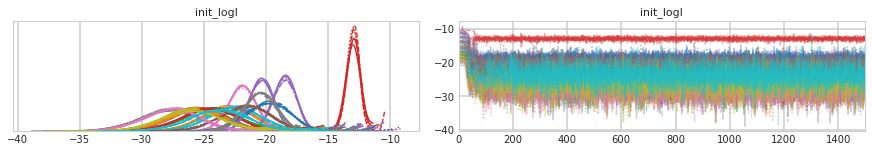

In [99]:
arviz.plot_trace(tr.isel(draw=slice(0, None)), var_names=['init_logI'], compact=True);

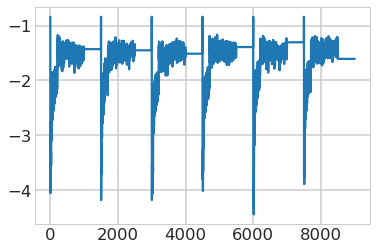

In [101]:
plt.plot(np.log10(trace.step_size))

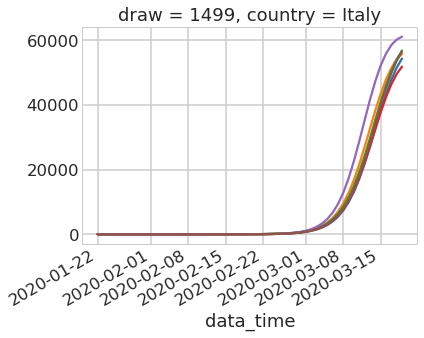

In [105]:
((tr.solution_I) * xr.DataArray(countries['population'])).isel(country=4, draw=-1).plot.line(x='data_time', add_legend=False);

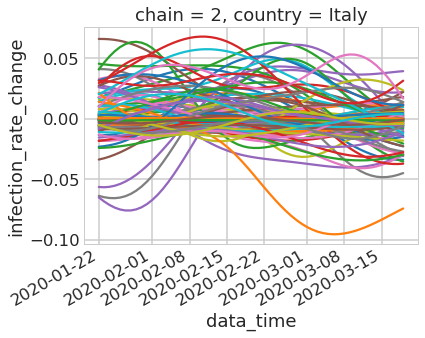

In [112]:
tr.infection_rate_change.sel(country='Italy', chain=2).isel(draw=slice(-100, None)).plot.line(x='data_time', add_legend=False);

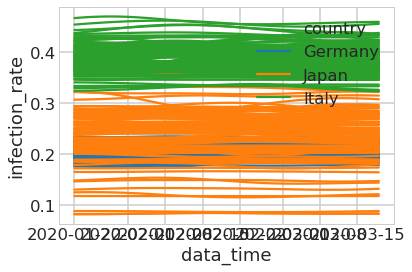

In [115]:
sns.lineplot(
    x='data_time',
    y='infection_rate',
    hue='country',
    units='draw',
    estimator=None,
    data = (
        tr.infection_rate
        #.rename('infection_rate')
        .sel(country=['Germany', 'Japan', 'Italy'])
        .sel(chain=2)
        #.isel(country=slice(5))
        .isel(draw=slice(-100, None))
        .to_dataframe()
        .reset_index()
    )
)

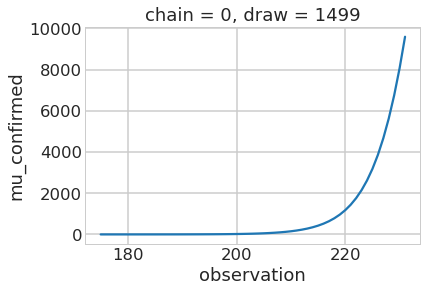

In [123]:
tr.mu_confirmed.sel(observation=df_sign[df_sign.country == 'Germany'].index).isel(chain=0, draw=-1).plot()

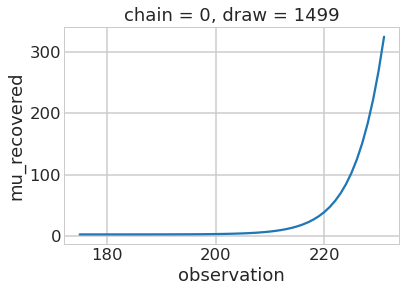

In [124]:
tr.mu_recovered.sel(observation=df_sign[df_sign.country == 'Germany'].index).isel(chain=0, draw=-1).plot()

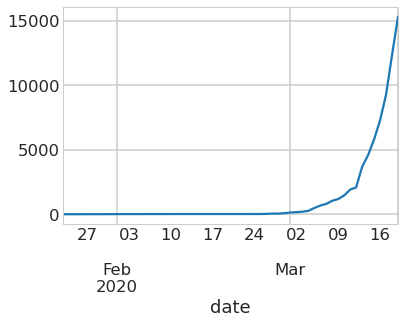

In [125]:
df_sign.query("country == 'Germany'").set_index('date').confirmed.plot()

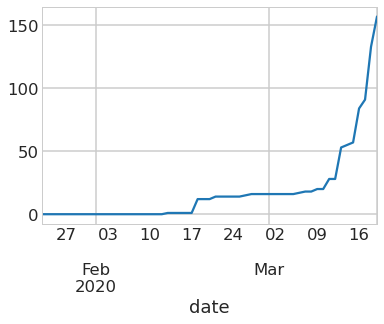

In [126]:
df_sign.query("country == 'Germany'").set_index('date').eval('recovered + deaths').plot()

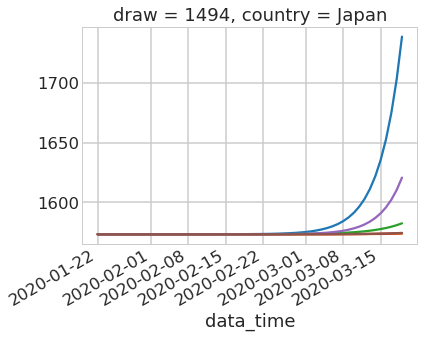

In [127]:
((1 - tr.solution_S) * xr.DataArray(countries['population'])).isel(country=0, draw=-6).plot.line(x='data_time', add_legend=False);

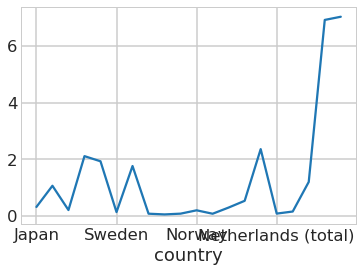

In [128]:
tr.confirmed_alpha.median(['draw', 'chain']).to_pandas().plot()

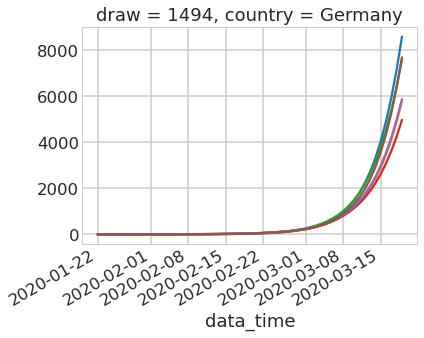

In [129]:
((1 - tr.solution_S) * xr.DataArray(countries['population'])).isel(country=3, draw=-6).plot.line(x='data_time', add_legend=False);

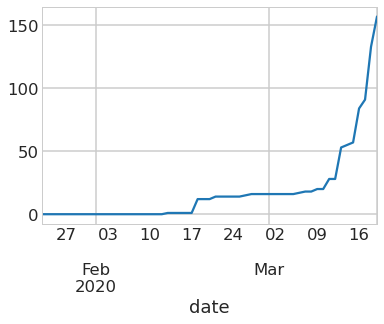

In [130]:
df_sign.query("country == 'Germany'").set_index('date').eval('recovered + deaths').plot()

In [42]:
beta = tt.dscalar('__beta')
beta.tag.test_value = 1.
priors = tt.sum([var.logpt for var in model.free_RVs])
observed = tt.sum([var.logpt for var in model.observed_RVs])

func = pm.model.ValueGradFunction(priors + beta * observed, model.free_RVs, [beta])

func.set_extra_values({beta.name: 1.})


class TemperingAdapt(pm.step_methods.hmc.quadpotential.QuadPotentialFull):
    """Adapt a dense mass matrix using the sample covariances."""
    def __init__(
        self,
        n,
        initial_mean,
        initial_cov,
        func,
        n_tune,
        n_steps,
        n_tempering,
        update_window=50,
        initial_weight=100,
        dtype=None,
    ):
        #self._betas = list(np.linspace(0, 1, n_steps)[1:])
        #self._betas = list(np.logspace(-3, 0, n_steps)[1:])
        self._n_steps = n_steps
        #self._betas = list(np.repeat(scipy.special.expit(np.linspace(-8, 4, n_steps // 3)), 2))
        #self._betas = list(np.repeat(scipy.special.expit(np.linspace(-7, 5, n_steps // 3)), 2))
        #self._betas.extend([1] * n_steps)
        
        self._window_length = n_tune // n_steps
        self._window = 0
        self._func = func
        self._n_tempering = n_tempering
        
        self._func.set_extra_values({'__beta': self.get_beta(0)})

        if initial_cov is not None and initial_cov.ndim != 2:
            raise ValueError("Initial covariance must be two-dimensional.")
        if initial_mean.ndim != 1:
            raise ValueError("Initial mean must be one-dimensional.")
        if initial_cov is not None and initial_cov.shape != (n, n):
            raise ValueError(
                "Wrong shape for initial_cov: expected %s got %s"
                % (n, initial_cov.shape)
            )
        if len(initial_mean) != n:
            raise ValueError(
                "Wrong shape for initial_mean: expected %s got %s"
                % (n, len(initial_mean))
            )

        if dtype is None:
            dtype = theano.config.floatX

        if initial_cov is None:
            initial_cov = np.eye(n, dtype=dtype)
            initial_weight = 1

        self.dtype = dtype
        self._n = n
        self._cov = np.array(initial_cov, dtype=self.dtype, copy=True)
        self._chol = scipy.linalg.cholesky(self._cov, lower=True)
        self._chol_error = None
        self._foreground_cov = pm.step_methods.hmc.quadpotential._WeightedCovariance(
            self._n, initial_mean, initial_cov, initial_weight, self.dtype
        )
        self._background_cov = pm.step_methods.hmc.quadpotential._WeightedCovariance(self._n, dtype=self.dtype)
        self._n_samples = 0

        self._update_window = int(update_window)
        self._previous_update = 0
        
    def get_beta(self, i):
        a = -7
        b = 4
        return scipy.special.expit((b - a) * i / self._n_tempering + a)
        #return i / self._n_tempering
    
    def _update_from_weightvar(self, weightvar):
        weightvar.current_covariance(out=self._cov)
        if self._n_samples < self._n_tempering / 3:
            self._cov = np.diag(np.diag(self._cov))

        try:
            self._chol = scipy.linalg.cholesky(self._cov, lower=True)
            #self._chol = np.sqrt(self._cov)
        except (scipy.linalg.LinAlgError, ValueError) as error:
            self._chol_error = error

    def update(self, sample, grad, tune, stepadapt):
        if not tune:
            return

        # Steps since previous update
        delta = self._n_samples - self._previous_update

        self._foreground_cov.add_sample(sample, weight=1)
        self._background_cov.add_sample(sample, weight=1)

        if self._n_samples < self._n_tempering:
            self._func.set_extra_values({'__beta': self.get_beta(self._n_samples)})
            #self._func.set_extra_values({'__beta': 1.})
        elif self._n_samples == self._n_tempering:
            stepadapt.reset(0.6)
            self._func.set_extra_values({'__beta': 1.})
            #lib.CVodeSStolerances(solver._ode, 1e-14, 1e-14)
            #lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-12, 1e-12)
            #lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-12, 1e-12)

        # Reset the background covariance if we are at the end of the adaptation
        # window.
        if delta >= self._window_length:
            self._foreground_cov = self._background_cov
            self._background_cov = pm.step_methods.hmc.quadpotential._WeightedCovariance(
                self._n, dtype=self.dtype
            )

            self._previous_update = self._n_samples
            self._window += 1
            self._update_from_weightvar(self._foreground_cov)
            if self._n_samples >= 2 * self._n_steps // 3:
                self._window_length *= 1.5
        #else:
        # Update the covariance matrix and recompute the Cholesky factorization
        # every "update_window" steps
        #    if self._window >= self._n_steps // 2 and (delta + 1) % self._update_window == 0:
        #        self._update_from_weightvar(self._foreground_cov)
                
        self._n_samples += 1

    def raise_ok(self, vmap):
        if self._chol_error is not None:
            raise ValueError("{0}".format(self._chol_error))

In [44]:
with model:
    prior = pm.sample_prior_predictive(10)

stds = {name: vals.std(0) for name, vals in prior.items() if vals.ndim > 0}
means = {name: vals.mean(0) for name, vals in prior.items() if vals.ndim > 0}
points = [{name: vals[i] for name, vals in prior.items() if vals.ndim > 0} for i in range(6)]

import scipy.special


/home/adr/anaconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [45]:
with model:
    pot = TemperingAdapt(
        func.size,
        func.dict_to_array(means),
        np.diag(func.dict_to_array(stds) ** 2),
        func,
        4_000,
        15,
        3300,
    )
    step = pm.NUTS(func=func, potential=pot, k=0.6, max_treedepth=10, target_accept=0.6)
    
    trace = pm.sample(
        tune=4000, draws=1000, step=step,
        discard_tuned_samples=False, chains=6, cores=6,
        start=points, compute_convergence_checks=False
    )

Multiprocess sampling (6 chains in 6 jobs)
NUTS: [recovered_alpha, confirmed_alpha, infection_change_polys_raw, infection_change_polys_sd, log_remiss_raw, log_remiss_mu, log_remiss_sd, log_infect_raw, log_infect_mu, log_infect_sd, init_logI_raw, init_logI_mu, init_logI_sd]
